In [1]:
import sys
import tarfile
from scipy.io import loadmat
import glob
import numpy as np
import os
from shutil import copyfile, rmtree
import json

Checking which Python version is used to determines which module to import for the 'urlretrieve' function based on the Python version.

In [2]:
if sys.version_info[0] >= 3:
    from urllib.request import urlretrieve
else:
    from urllib import urlretrieve

download_file function is used to download a file from a given URL.

In [3]:
def download_file(url, dest=None):
    if not dest:
        dest = os.path.join(data_path, url.split('/')[-1])
    urlretrieve(url, dest)

In [4]:
data_path = 'flower'

Checking for the existence of the '102flowers.tgz' archive and 'imagelabels.mat' file in the specified data_path.

In [5]:
if not os.path.exists(data_path):
    os.mkdir(data_path)
flowers_archive_path = os.path.join(data_path, '102flowers.tgz')
if not os.path.isfile(flowers_archive_path):
    print ('Downloading images...')
    download_file('http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz')
    tarfile.open(flowers_archive_path).extractall(path=data_path)

image_labels_path = os.path.join(data_path, 'imagelabels.mat')
if not os.path.isfile(image_labels_path):
    print("Downloading image labels...")
    download_file('http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat')

image_labels contains the flower labels, properly converted to a zero-indexed representation

In [6]:
image_labels = loadmat(image_labels_path)['labels'][0]
image_labels -= 1

labels NumPy array will contain the file paths and their corresponding image labels

In [7]:
files = sorted(glob.glob(os.path.join(data_path, 'jpg', '*.jpg')))
labels = np.array([i for i in zip(files, image_labels)])

In [8]:
cwd = os.getcwd()

The files are copied from their original locations to the respective class directories based on their labels.

In [9]:
def move_files(dir_name,cwd,labels):
    cur_dir_path = os.path.join(cwd, dir_name)
    if not os.path.exists(cur_dir_path):
        os.mkdir(cur_dir_path)
    for i in range(0, 102):
        class_dir = os.path.join(cwd, dir_name, str(i))
        os.mkdir(class_dir)
    for label in labels:
        src = str(label[0])
        dst = os.path.join(cwd,dir_name, label[1], src.split(os.sep)[-1])
        copyfile(src, dst)

In [10]:
dir_name=os.path.join(data_path,'class')
move_files(dir_name,cwd,labels)

content will be saved as a JSON file with the specified filename. The file will contain the data from the dictionary in a JSON format.

In [11]:
def save_dict(content,filename):
    content = dict(content)
    with open(filename,'w') as file_object:
        json.dump(content,file_object)

Reading the data from the specified JSON file and return it as a Python dictionary.

In [12]:
def load_dict(filename):
    with open(filename,'r') as file_object:
        content = json.load(file_object)
    return content

In [13]:
save_dict(labels,os.path.join(data_path,'image-label.json'))

Working with image data and extract labels from image file paths

In [14]:
from fastai.vision.all import *

# Set your data path (same as in your previous code)
data_path = 'flower'

# Define a function to get the image files
def get_image_files(path, folders=None):
    return get_files(path, extensions='.jpg', recurse=True)

# Define the path to the folder containing your images (class folder)
image_folder_path = os.path.join(data_path, 'class')

# Create a function to get the label from the image file path
def get_label(file_path):
    return int(file_path.parent.name)

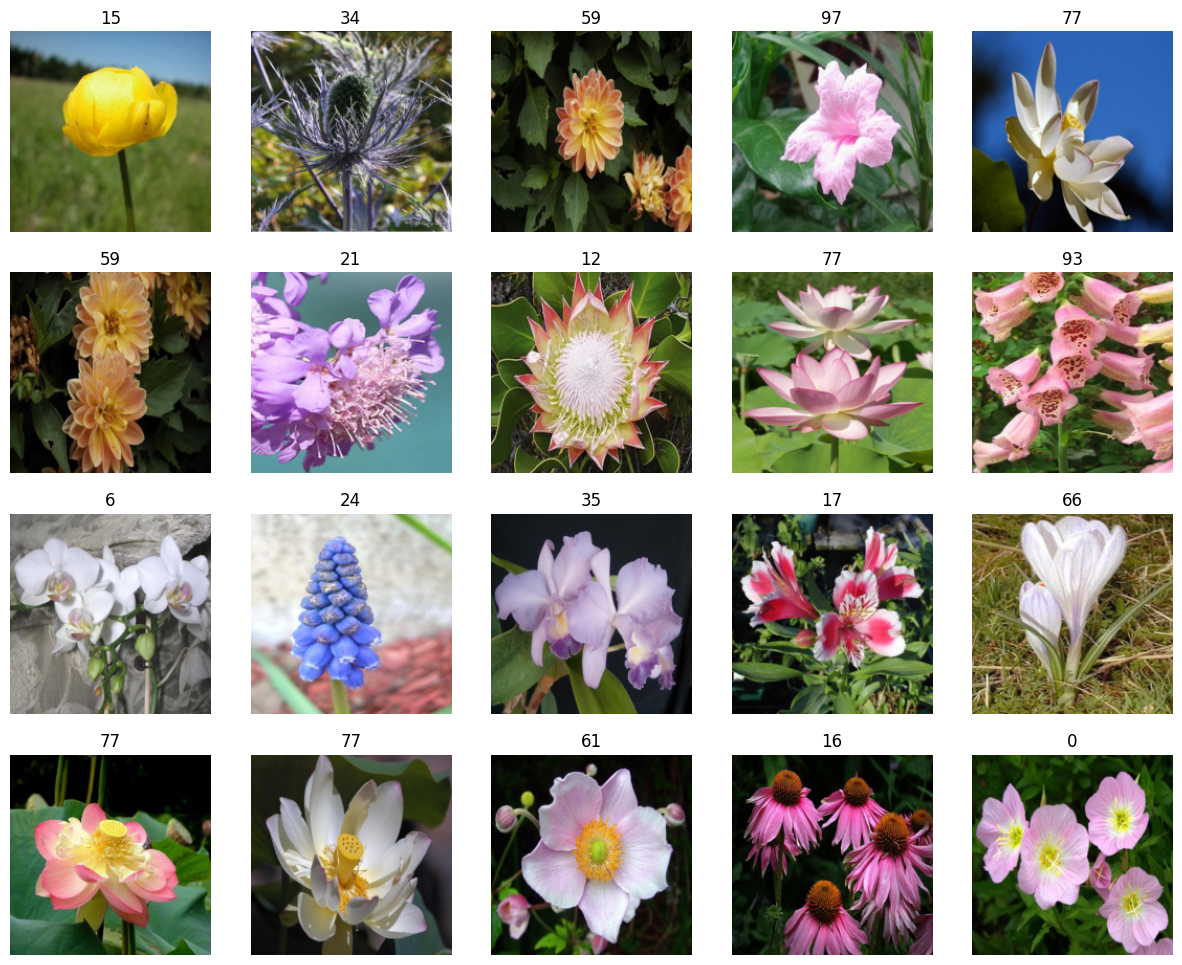

In [15]:
# DataBlock definition
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=get_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(image_folder_path, bs=64)
dls.show_batch(max_n=20)

Calculating the number of images in each class (class folder) within the specified data_path directory

In [16]:
import os

data_path = 'flower'  # Set your data path

# Define the path to the folder containing your images (class folder)
image_folder_path = os.path.join(data_path, 'class')

# Create a dictionary to store the count of images in each class
class_counts = {}

# Loop through each subdirectory (class folder) and count the number of images in each class
for class_dir in os.listdir(image_folder_path):
    class_id = int(class_dir)  # Convert the class folder name to an integer (class ID)
    class_path = os.path.join(image_folder_path, class_dir)
    num_images = len(os.listdir(class_path))  # Count the number of images in the class folder
    class_counts[class_id] = num_images

# Print the counts of images in each class
for class_id, count in class_counts.items():
    print(f"Class {class_id}: {count} images")


Class 21: 59 images
Class 0: 40 images
Class 56: 67 images
Class 17: 82 images
Class 99: 49 images
Class 100: 58 images
Class 90: 76 images
Class 93: 162 images
Class 54: 71 images
Class 89: 82 images
Class 49: 92 images
Class 53: 61 images
Class 24: 41 images
Class 39: 67 images
Class 52: 93 images
Class 10: 87 images
Class 65: 61 images
Class 29: 85 images
Class 58: 67 images
Class 27: 66 images
Class 80: 166 images
Class 43: 93 images
Class 45: 196 images
Class 78: 41 images
Class 8: 46 images
Class 61: 55 images
Class 2: 40 images
Class 32: 46 images
Class 98: 63 images
Class 64: 102 images
Class 87: 154 images
Class 9: 45 images
Class 11: 87 images
Class 95: 91 images
Class 37: 56 images
Class 5: 45 images
Class 97: 82 images
Class 60: 50 images
Class 22: 91 images
Class 70: 78 images
Class 77: 137 images
Class 74: 120 images
Class 85: 58 images
Class 40: 127 images
Class 86: 63 images
Class 48: 49 images
Class 41: 59 images
Class 23: 42 images
Class 6: 40 images
Class 73: 171 ima

In [17]:
learn = vision_learner(dls, resnet50, metrics=F1Score(average="weighted"))
learn.fine_tune(30)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 239MB/s]


epoch,train_loss,valid_loss,f1_score,time
0,1.902896,0.538959,0.847114,01:15


epoch,train_loss,valid_loss,f1_score,time
0,0.420557,0.298560,0.925465,01:04
1,0.208740,0.249982,0.931336,01:05


epoch,train_loss,valid_loss,f1_score,time
0,0.420557,0.298560,0.925465,01:04
1,0.208740,0.249982,0.931336,01:05
2,0.092351,0.199994,0.945767,01:05
3,0.032106,0.162863,0.953766,01:06
4,0.015720,0.151143,0.958795,01:06


In [18]:
learn.export('model.pkl')

In [19]:
lis = [i for i in range(101)]
os.mkdir("newclass")
for i in lis:
  os.mkdir('newclass/{}'.format(i))

In [20]:
import os
from fastai.vision.all import *

# Define a function to get the image files
def get_image_files(path, folders=None):
    return get_files(path, extensions='.jpg', recurse=True)

# Create a function to get the label from the image file path
def get_label(file_path):
    return int(file_path.parent.name)

# Define the path to the folder containing your images (class folder)
image_folder_path = '/content/newclass'


In [21]:
from fastai.vision.all import *

learn =load_learner('model.pkl')

In [22]:
is_this_zero_category,_,probs = learn.predict(PILImage.create('flower/class/0/image_06734.jpg'))
print(f"This is a: {is_this_zero_category}.")
print(f"Probability this is Zero Category: {probs[0]:.4f}")

This is a: 0.
Probability this is Zero Category: 0.9822


In [ ]:
!pip install gradio

In [24]:
from fastai.vision.all import *
import gradio as gr

def is_flower_category(x):
  return x[0].issuper()

In [ ]:
im= PILImage.create('flower/newclass/97/image_07751.jpg')
im = im.resize((192, 192), resample=Image.LANCZOS)
im.show()

In [ ]:
learn.predict(im)

In [ ]:
categories = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
              21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
              41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
              61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80,
              81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101)

def classify_image(img):
  pred,idx,probs = learn.predict(img)
  return dict(zip(categories,map(float,probs)))

In [ ]:
classify_image(im)

In [ ]:
image=gr.inputs.Image(shape=(192,192))
label=gr.outputs.Label()
# #examples =['flower/class/97/image_07751.jpg', 'flower/class/19/image_04897.jpg',
#            'flower/class/83/image_02553.jpg', 'flower/class/33/image_06930.jpg',
#            'flower/class/79/image_01964.jpg', 'flower/class/90/image_04840.jpg']

intf = gr.Interface(fn=classify_image, inputs=image, outputs=label)
intf.launch(inline=False, share=True)